###  <span style="color:red">**This Notebook can be run from Google Colab:**</span>

https://colab.research.google.com

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile
import shutil
from google.colab import files
import json
import time
import pandas as pd

import keras
from keras.models import Model, Sequential, load_model
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,\
                          Conv2D, MaxPooling2D, Flatten, AveragePooling2D,\
                          GlobalAveragePooling2D, ZeroPadding2D
from keras.initializers import glorot_uniform
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, \
                            classification_report

# Import PyDrive and associated libraries (to connect with GoogleDrive)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# disable warnings
import warnings
warnings.simplefilter("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### **Check if we are using GPU:**

In [0]:
from keras import backend as K
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.15.0 , GPU: /device:GPU:0


### **Download Patches from GoogleDrive:**

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1AbZppC-Fe_fVI1mslm7BP8PBSoOu3u36' #Pos_vs_Neg_128_s60_VS_22 .... min1250_minval_1024_inclborder FULL BALANCE

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
print('Downloaded content: "{}"'.format(downloaded['title']))
print('Root dir content: {}'.format(os.listdir()))

Downloaded content: "Patches_pos_vs_neg_128_s60_vs22_min1250_minval_1024_inclborder_noStreak_yes_cls_balance_yes_pos_neg_balance.zip"
Root dir content: ['.config', 'Patches', 'gdrive', 'adc.json', 'base_model.h5', 'Patches_pos_vs_neg_128_s60_vs22_min1250_minval_1024_inclborder_noStreak_yes_cls_balance_yes_pos_neg_balance.zip', 'model_pos_neg.h5', 'history_dict.json', 'sample_data']


### **Unzip the Patches:**

In [0]:
# Remove 'Patches' dir if it already exists
if 'Patches' in os.listdir():
  shutil.rmtree('./Patches')
with zipfile.ZipFile(downloaded['title'],"r") as zip:
    zip.extractall()
os.remove(downloaded['title'])
print('Root dir content: {}'.format(os.listdir()))

Root dir content: ['.config', 'Patches', 'gdrive', 'adc.json', 'base_model.h5', 'model_pos_neg.h5', 'history_dict.json', 'sample_data']


### **Let's count patches by type and location and save class weights in inverse proportion to the number of patches for each class:**

In [0]:
class_weights = {} # empty dictionary to store class weights
for type_ in ['Serial', 'Control', 'Streak']:
    class_weights[type_] = {} # nested empty dictionary to store class weights
    pos_folder = './Patches/{}/pos'.format(type_)
    neg_folder = './Patches/{}/neg'.format(type_)
    n_pos = len(os.listdir(pos_folder))
    n_neg = len(os.listdir(neg_folder))
    total = n_pos + n_neg
    class_weights[type_]['neg'] = total/n_neg if n_neg else 0
    class_weights[type_]['pos'] = total/n_pos if n_pos else 0
    print('total_{}: {} = {} positive + {} negative'.format(type_,total,n_pos,n_neg))
print('\nclass_weights:', str(json.dumps(class_weights, indent=2, default=str)))

total_Serial: 45660 = 22830 positive + 22830 negative
total_Control: 7420 = 3710 positive + 3710 negative
total_Streak: 0 = 0 positive + 0 negative

class_weights: {
  "Serial": {
    "neg": 2.0,
    "pos": 2.0
  },
  "Control": {
    "neg": 2.0,
    "pos": 2.0
  },
  "Streak": {
    "neg": 0,
    "pos": 0
  }
}


#### **Let's build image generators, using keras.preprocessing.image.ImageDataGenerator, rescaling image pixel values from [0,  255] to [0, 1]:**

In [0]:
serial_pos_folder = './Patches/Serial/pos'
img = plt.imread(serial_pos_folder + '/' + os.listdir(serial_pos_folder)[:5][0])
img_size = img.shape
train_batch_size = 32
val_batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

print("For training:")
train_generator = datagen.flow_from_directory(
        './Patches/Serial',
        target_size=(img_size[0],img_size[1]),
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True)

print("\nFor validation:")
val_generator = val_datagen.flow_from_directory(
        './Patches/Control',
        target_size=(img_size[0],img_size[1]),
        batch_size=val_batch_size,
        class_mode='categorical',
        shuffle=False)

For training:
Found 45660 images belonging to 2 classes.

For validation:
Found 7420 images belonging to 2 classes.


#### **Let's check what is the train generators' index for each class, so we can correclty set up the class weights:**

In [0]:
print('train_generator.class_indices:', str(json.dumps(train_generator.class_indices, indent=2, default=str)))

train_generator.class_indices: {
  "neg": 0,
  "pos": 1
}


#### **Let's set up the class weights in correct order:**

In [0]:
serial_pos_weights = []
classes = ['neg','pos']
for cls in classes:
    serial_pos_weights.append(class_weights['Serial']['{}'.format(cls)])
print('original class weights dictionary:')
print(str(json.dumps(class_weights['Serial'], indent=2, default=str)))
print('class weights for generator, re-arranging indexes:')
print(str(json.dumps(serial_pos_weights, indent=2, default=str)))

original class weights dictionary:
{
  "neg": 2.0,
  "pos": 2.0
}
class weights for generator, re-arranging indexes:
[
  2.0,
  2.0
]


## **Let's build our Base Model. We will use Resnet:**

#### **First. let's create a function to build a residual block.**

#### We will use the residual block proposed in  [ResNetV2](https://arxiv.org/pdf/1603.05027.pdf) and will implement it by ourselves:


>![Google's logo](https://camo.githubusercontent.com/7ae470c333cd76078e1c669055ad98bcedaf523f/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3130303532332f61313536613563322d303236622d646535352d613666622d6534666131373732623432632e706e67)

In [0]:
def res_block(X, filters, kernel_size=(3,3), l2_reg=1e-6, residual=True,
              first=False, subsampling=False):
    """
    Function to build a residual block as proposed in ResNetV2:
             https://arxiv.org/pdf/1603.05027.pdf:
    :param X: The input to the residual block
    :param filters: Integer. Number of filters / channels in the output
    :param kernel_size: Tuple (Int, Int). kernel size for convolution operations
    :param l2_reg: Float. L2 norm for L2 regularization
    :param residual: Boolean. True if residual block. Otherwise 'plain' block.
    :param first: Boolean. True if first residual block -> ZeroPad and Maxpool.
    :param subsampling: Boolean. True if subsampling within the residual block.
    :return: the addition output from the residual block proposed in ResNetV2:
              https://arxiv.org/pdf/1603.05027.pdf
    """
    bn = BatchNormalization()(X)
    relu = Activation("relu")(bn)
    
    if first: #The first layer is subsampled with Maxpool
      pad = ZeroPadding2D(padding=(1, 1))(relu)
      relu = MaxPooling2D(pool_size=(3, 3), strides=(2,2))(pad)    
    
    if subsampling: #Resnet reduces size just by using stride=2 instead of pool
      #Here we will reduce the size (subsample) by using stride 2 
      conv_1 = Conv2D(filters, kernel_size, strides=(2,2), padding='same',
                         kernel_regularizer=regularizers.l2(l2_reg),
                         kernel_initializer = glorot_uniform(0),
                         bias_initializer = glorot_uniform(0))(relu)
      if residual:
        #To be able to add, we also need to reduce size of input
        #For this, we will just use a 1x1 Conv2D with stride 2  
        res = Conv2D(filters, kernel_size=[1,1], strides=(2,2),
                     padding='same')(X)
    else: #No subsampling, same size as input
      conv_1 = Conv2D(filters, kernel_size, strides=(1,1), padding='same',
                   kernel_regularizer=regularizers.l2(l2_reg),
                   kernel_initializer = glorot_uniform(0),
                   bias_initializer = glorot_uniform(0))(relu)
      if residual:
        if first: #The first layer is subsampled with Maxpool so, resize X
          #For this, we will just use a 1x1 Conv2D with stride 2
          res = Conv2D(filters, kernel_size=[1,1], strides=(2,2),
                     padding='same')(X)
        else:
          res = X
    bn = BatchNormalization()(conv_1)
    relu = Activation("relu")(bn)

    conv_2 = Conv2D(filters, kernel_size, padding='same',
                       kernel_regularizer=regularizers.l2(l2_reg),
                       kernel_initializer = glorot_uniform(0),
                       bias_initializer = glorot_uniform(0))(relu)
    if residual:
      add = keras.layers.add([res, conv_2])
      return add
    else:
      return conv_2

#### **Second, let's create a function to build a Resnet network:**

In [0]:
#from keras.layers import AveragePooling2D, GlobalAveragePooling2D

def make_resnet(img_size, n_classes, layers_per_group, n_filters, 
                    kernel_sizes, l2_reg=1e-6, optimizer=keras.optimizers.SGD,
                    lr=1e-1, decay=1e-4, momentum=0.9, residual=True):
  
    """
    Function to build ResNet network, but with some user defined parameters.
        
        ResNet network input size is (224,224,3) then it starts with one 
        convolution layer, (7x7x64, stride 2) followed by maxpool (3x3, stride2) 
        then it will build 4 layer groups and the user will define the number of
        residual layers per group.
        
        As example, ResNet34, after the first convolution layer, it has 4 groups
        of layers with the following number of residual 'layers_per_group':
        [6,8,12,6]
        Because the residual connections are made between pair of layers, the
        number of layers for each group must be a pair number.
        
        The user will also be able to define the number of filters and size of
        each filter, independently for each group of layers. All layers in the
        same group group will have the same number of filters and each filter
        within the group will have the same size.
        
        Same as ResNet, an average pooling layer follows after the 4 groups
        of layers.
    
    :param img_size: Size of input image, in the form: (size, size, #channels)
    :param n_classes: Integer. Number of classes for classification.
    :param layers_per_group: List with # of layers per group (e.g.[6,8,12,6])
    :param n_filters: List of length 4, with number of filters for each group of
                      layers.
    :param kernel_sizes: List of length 4, with kernel sizes tuples for each 
                          group of layers
    :param l2_reg: Float. L2 norm for L2 regularization
    :param optimizer: A keras optimizer from keras.optimizers
    :param lr: Float. learning rate for the optimizer.
    :param decay: Float. learning rate decay for the optimizer.
    :param momentum: Float. Momentum for SGD if optimizer=keras.optimizers.SGD
    :param residual: Boolean. True if residual net. Otherwise 'plain' net.
    :return: CNN with residual connections, similar to ResNet32
    """
    
    if len(layers_per_block) != len(n_filters) or len(layers_per_block) !=\
        len(kernel_sizes) or len(n_filters) != len(n_filters):
        e = "Length of 'layers_per_block', 'n_filters' and 'kernel_sizes'" +\
        " must be the same"
        raise Exception(e)  

    for layers in layers_per_block:
      if layers % 2 == 1:
        e = "Number of 'layers_per_block' must be even/pair numbers"
        raise Exception(e)
      
    inputs = Input(shape=img_size)
    
    n_filters_conv1 = 64
    kernel_sizes_conv1 = (3,3)
    #kernel_sizes_conv1 = (5,5)
    #kernel_sizes_conv1 = (7,7)
    strides_conv1 = (2,2)
    
    conv1 = Conv2D(n_filters_conv1, kernel_sizes_conv1, strides=strides_conv1,
                   padding='same', kernel_regularizer=regularizers.l2(l2_reg),
                   kernel_initializer = glorot_uniform(0),
                   bias_initializer = glorot_uniform(0))(inputs)
    
    layer_count = 1 # counter for the number of layers
    
   
    for i in range(len(layers_per_block)):
      for j in range(int(layers_per_block[i]/2)):
        if j == 0:
          if i == 0:
            add = res_block(conv1, n_filters[i], kernel_sizes[i], l2_reg,
                            residual, first=True)
            #add = res_block(conv0_1, n_filters[i], kernel_sizes[i], l2_reg,
            #                residual, subsampling=True)
          else:
            add = res_block(add, n_filters[i], kernel_sizes[i], l2_reg,
                            residual, subsampling=True)
        else:
          add = res_block(add, n_filters[i], kernel_sizes[i], l2_reg,
                          residual)
          
    bn = BatchNormalization()(add)
    relu = Activation("relu")(bn)

    #pool = AveragePooling2D(pool_size=(2 ,2), padding='same')(relu)
    #flat = Flatten()(pool)
    flat = GlobalAveragePooling2D()(relu)

    out = Dense(n_classes, activation='softmax',
                      kernel_regularizer=regularizers.l2(l2_reg),
                      kernel_initializer=glorot_uniform(0),
                      bias_initializer=glorot_uniform(0))(flat)

    res_cnn = Model(inputs=inputs, outputs=out)

    if optimizer == keras.optimizers.Nadam:
        res_cnn.compile(optimizer(lr=lr, schedule_decay=decay),
                    "categorical_crossentropy", metrics=['accuracy'])
    elif optimizer == keras.optimizers.SGD:
        res_cnn.compile(optimizer(lr=lr, momentum=momentum, decay=decay),
                        "categorical_crossentropy", metrics=['accuracy'])
    else:
        res_cnn.compile(optimizer(lr=lr, decay=decay),
                        "categorical_crossentropy", metrics=['accuracy'])
    return res_cnn

### **Let's build a ResNet18:**

In [0]:
classes = list(iter(train_generator.class_indices))
n_classes = len(classes)
layers_per_block = [4, 4, 4, 4] #18 layers total with first conv and last FC
n_filters = [64, 128, 256, 512]
kernel_sizes = [(3,3), (3,3), (3,3), (3,3)]
l2_reg = 0.1
optimizer = RMSprop # Adamax, RMSprop, Adam (No: Nadam, SGD)
lr = 1e-3
decay = 0.01
momentum = 0.9

res_cnn = make_resnet(img_size, n_classes, layers_per_block, n_filters,
                       kernel_sizes, l2_reg, optimizer, lr, decay, momentum)
res_cnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 64, 64, 64)   256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 64, 64, 64)   0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

#### **Let's mount our GoogleDrive so we can later download the best model:***

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Let's train and validate our Base Model:**

In [0]:
#Pos_vs_Neg_128_s60_VS_22 .... min1250_minval_1024_inclborder FULL BALANCE

## No Rotations
## train_batch_size = 32

## 128x128 stride_60
## min_pos_pix_1250, mivalpos_1024
## INCLUDING dish_border on training images
## l2_reg = 0.1
## lr = 1e-3  
## opt_RMSprop, first_Kernel:3x3 (original ResNet is 7x7)

epochs = 50

train_steps = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size

# Callbacks:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=3, 
                                   verbose=1, mode='min', min_lr=1e-9)
EarlyStop = EarlyStopping(monitor='val_acc', patience=70, verbose=1,
                          min_delta=0, mode='max')
checkpoint = ModelCheckpoint('base_model.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

callbacks_list = [reduce_lr, checkpoint, EarlyStop] #order matters!

#res_cnn.load_weights('base_model.h5')

history = res_cnn.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=val_generator,
                            validation_steps=val_steps, epochs=epochs,
                            verbose=1, callbacks=callbacks_list, shuffle=False,
                            class_weight=serial_pos_weights)

Epoch 1/50
1426/1426 [==============================] - 64s 45ms/step - loss: 2.6357 - acc: 0.9579 - val_loss: 0.2189 - val_acc: 0.9947

Epoch 00001: val_acc improved from -inf to 0.99470, saving model to base_model.h5
Epoch 2/50
1426/1426 [==============================] - 59s 42ms/step - loss: 0.1929 - acc: 0.9863 - val_loss: 0.1700 - val_acc: 0.9923

Epoch 00002: val_acc did not improve from 0.99470
Epoch 3/50
1426/1426 [==============================] - 59s 41ms/step - loss: 0.1457 - acc: 0.9909 - val_loss: 0.2336 - val_acc: 0.9562

Epoch 00003: val_acc did not improve from 0.99470
Epoch 4/50
1426/1426 [==============================] - 59s 41ms/step - loss: 0.1207 - acc: 0.9937 - val_loss: 0.1352 - val_acc: 0.9861

Epoch 00004: val_acc did not improve from 0.99470
Epoch 5/50
1426/1426 [==============================] - 59s 41ms/step - loss: 0.1104 - acc: 0.9947 - val_loss: 0.1096 - val_acc: 0.9918

Epoch 00005: val_acc did not improve from 0.99470
Epoch 6/50
1426/1426 [===========

#### **Let's download the best model to our 'Capstone' folder in GoogleDrive:**

In [0]:
source = './base_model.h5'
dest = 'gdrive/My Drive/Capstone/model_pos_neg_2.h5'
shutil.copyfile(source, dest)

'gdrive/My Drive/Capstone/model_pos_neg_2.h5'

#### **Let's download the training history to a local file:**

In [0]:
for k,v in history.history.items():
  history.history[k] = str(v)

with open('history_dict.json', 'w') as f:
    json.dump(history.history, f)

try:
    time.sleep(3) # To avoid warning when downloading various files at once
    files.download('history_dict.json')
except:
    pass

In [0]:
#uploaded = files.upload()
with open('history_dict.json') as f:
    history_dict = json.load(f)
    
for k,v in history_dict.items():
  history_dict[k] = json.loads(v)

history_df = pd.DataFrame(history_dict)

#### **Let's plot training and validation loss vs epochs:**

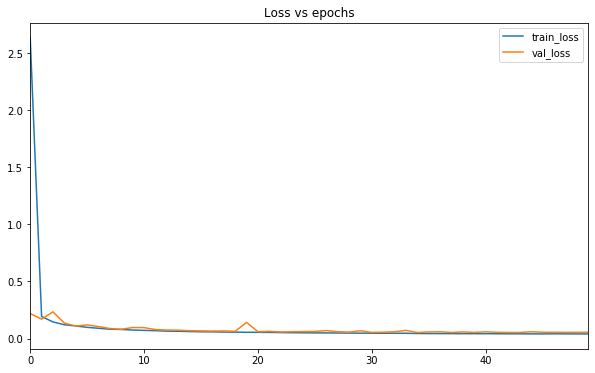

In [0]:
loss = history_df[['loss','val_loss']]
loss.columns = ['train_loss', 'val_loss']
loss.plot(figsize=(10, 6), title='Loss vs epochs')

#### **Let's plot training and validation accuracy vs epochs:**

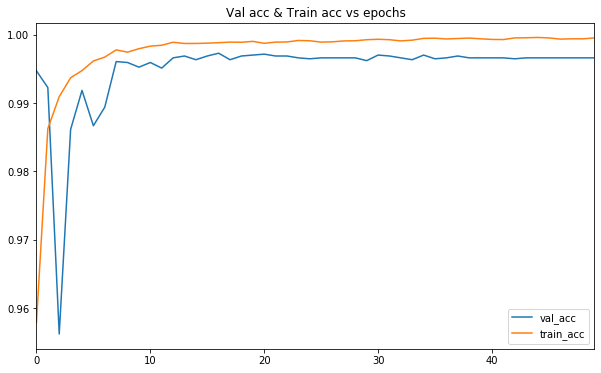

In [0]:
acc = history_df[['val_acc','acc']]
acc.columns = ['val_acc', 'train_acc']
acc.plot(figsize=(10, 6), title='Val acc & Train acc vs epochs')

#### **Let's plot learning rate vs epochs:**

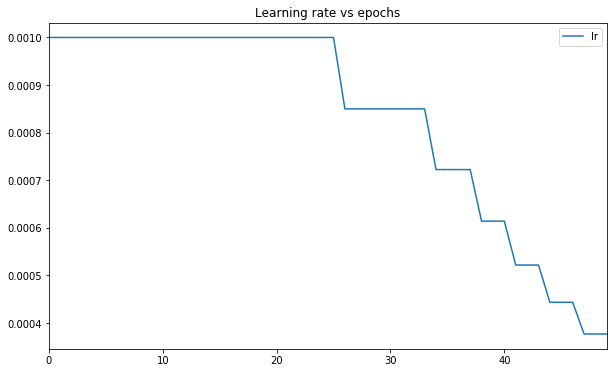

In [0]:
lr = history_df[['lr']]
lr.plot(figsize=(10, 6), title='Learning rate vs epochs')

#### **Let's evaluate the best model on the validation set and compute relevant metrics:**

In [0]:
res_cnn.load_weights('base_model.h5')

In [0]:
#Pos_vs_Neg_128_s60_VS_22 .... min1250_minval_1024_inclborder FULL BALANCE

## No Rotations
## train_batch_size = 32

## 128x128 stride_60
## min_pos_pix_1250, mivalpos_1024
## INCLUDING dish_border on training images
## l2_reg = 0.1
## lr = 1e-3  
## opt_RMSprop, first_Kernel:3x3 (original ResNet is 7x7)

X, y_true = next(val_generator)
y_pred = res_cnn.predict(X)
for i in range(1, len(val_generator)):
  X, y = next(val_generator)
  y_true = np.vstack((y_true, y))
  y_pred = np.vstack((y_pred, res_cnn.predict(X)))

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

val_acc = accuracy_score(y_true, y_pred)
#roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
class_names = [k for k in val_generator.class_indices]
c_report = classification_report(y_true, y_pred, target_names=class_names)

print('\nval_acc:\n', val_acc)
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', c_report)


val_acc:
 0.9973045822102425

Confusion Matrix:
 [[3690   20]
 [   0 3710]]

Classification Report:
               precision    recall  f1-score   support

         neg       1.00      0.99      1.00      3710
         pos       0.99      1.00      1.00      3710

    accuracy                           1.00      7420
   macro avg       1.00      1.00      1.00      7420
weighted avg       1.00      1.00      1.00      7420



## **Let's evaluate the best model, when loaded from GoogleDrive:**

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1-BxPnguFXE7PHmzKadW0AnwWO9VqTywR' # model pos vs neg

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
print('Downloaded content: "{}"'.format(downloaded['title']))
print('Root dir content: {}'.format(os.listdir()))

Downloaded content: "model_pos_neg_2.h5"
Root dir content: ['.config', 'Patches', 'gdrive', 'model_pos_neg_2.h5', 'adc.json', 'base_model.h5', 'model_pos_neg.h5', 'history_dict.json', 'sample_data']


In [0]:
final_model = load_model(downloaded['title'])

In [0]:
## entire model loaded from GoogleDrive (not just weights)

X, y_true = next(val_generator)
y_pred = final_model.predict(X)
for i in range(1, len(val_generator)):
  X, y = next(val_generator)
  y_true = np.vstack((y_true, y))
  y_pred = np.vstack((y_pred, final_model.predict(X)))

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

val_acc = accuracy_score(y_true, y_pred)
#roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
class_names = [k for k in val_generator.class_indices]
c_report = classification_report(y_true, y_pred, target_names=class_names)

print('\nval_acc:\n', val_acc)
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', c_report)


val_acc:
 0.9973045822102425

Confusion Matrix:
 [[3690   20]
 [   0 3710]]

Classification Report:
               precision    recall  f1-score   support

         neg       1.00      0.99      1.00      3710
         pos       0.99      1.00      1.00      3710

    accuracy                           1.00      7420
   macro avg       1.00      1.00      1.00      7420
weighted avg       1.00      1.00      1.00      7420

